<a href="https://colab.research.google.com/github/lim-jr/ESAA/blob/main/0342%EA%B8%88%EA%B3%BC%EC%A0%9C_%ED%95%B8%EC%A6%88%EC%98%A8(245_271)_%EC%95%99%EC%83%81%EB%B8%94rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CHAPTER 7 : 항상블 학습과 랜덤 포레스트

---
## 7.1 투표 기반 분류기

* 앙상블 방법은 예측기가 가능한 한 서로 **독립적**일 때 최고의 성능을 발휘함. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 **높기** 때문에 앙상블 모델의 정확도를 향상시킴

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting = 'hard'
)

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

* **간접투표** : 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음
  * `voting = 'soft'`로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf, svm_clf,voting_clf) :
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


---
## 7.2 배깅과 페이스팅

1. `배깅` : 훈련세트에서 **중복을 허용**하여 샘플링 하는 방식
2. `페이스팅` : 중복을 허용하지 **않고** 샘플링 하는 방식

* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듬

  -> `수집함수 : 분류(통계적 최빈값) / 회귀 (평균)`
  
  -> 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 **편향**되어 있지만 수집 함수를 통과하면 편향과 분산이 **모두 감소**

### 7.2.1 사이킷런의 배깅과 페이스팅

* `bootstrap = False` : 페이스팅 사용
* `n_jobs` : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators = 500, max_samples = 100, bootstrap = True, n_jobs = -1
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

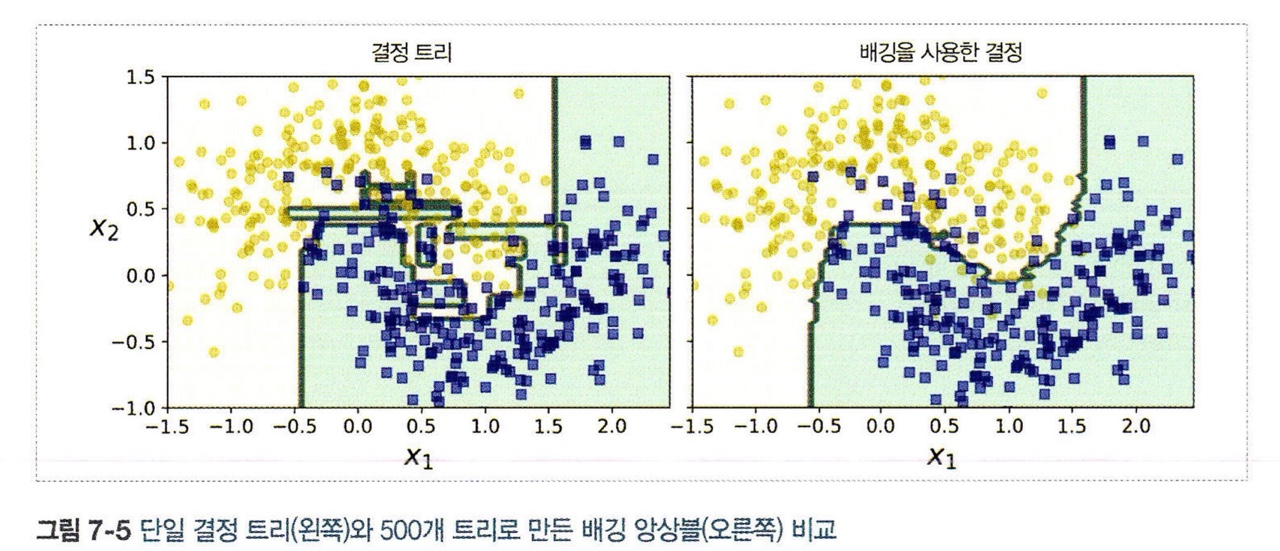

* 앙상블의 예측이 결정 트리 하나의 예측보다 **일반화가 훨씬 잘됨**
* 앙상블은 비슷한 편향에서 **더 작은 분산**을 만든다

### 7.2.2 oob 평가

* 사이킷런에서 **BaggingClassifier**를 만들 때 `oob_score = True`로 지정하면 훈련이 끝난 후 자동으로 oob평가 수행

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True
)

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.896

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

* oob샘플에 대한 결정함수의 값 -> 훈련 샘플의 **클래스 확률** 반환

In [ ]:
bag_clf.oob_decision_function_

array([[0.42180095, 0.57819905],
       [0.39459459, 0.60540541],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09039548, 0.90960452],
       [0.30177515, 0.69822485],
       [0.        , 1.        ],
       [0.98395722, 0.01604278],
       [0.95897436, 0.04102564],
       [0.77941176, 0.22058824],
       [0.00591716, 0.99408284],
       [0.71782178, 0.28217822],
       [0.78531073, 0.21468927],
       [0.97      , 0.03      ],
       [0.07978723, 0.92021277],
       [0.00526316, 0.99473684],
       [0.98245614, 0.01754386],
       [0.94857143, 0.05142857],
       [1.        , 0.        ],
       [0.0199005 , 0.9800995 ],
       [0.40340909, 0.59659091],
       [0.92021277, 0.07978723],
       [1.        , 0.        ],
       [0.95092025, 0.04907975],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.0052356 , 0.9947644 ],
       [0.6741573 , 0.3258427 ],
       [0.

---
## 7.3 랜덤 패치와 랜덤 서브스페이스

1. `랜덤패치 방식` : 훈련 특성과 샘플을 모두 샘플링하는 것
2. `랜덤 서브스페이스 방식` : 훈련 샘플을 모두 **사용** 하고 특성을 **샘플링**하는 것
  * `bootstrap = False` : 훈련 샘플 모두 사용
  * `bootstrap_features=True` & `max_features < 1.0` : 특성 샘플링 -> `더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤`

---
## 7.4 랜덤 포레스트
: 일반적으로 배깅방법(또는 페이스팅)을 적용한 결정 트리의 앙상블

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)

### 7.4.1 엑스트라 트리

1. `익스트림 랜덤 트리` : 극단적으로 **무작위한** 트리의 랜덤 포레스트
  * 편향이 **늘어나지만** 분산은 **낮춤**
  

### 7.4.2 특성 중요도

* 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정
* 결정 트리의 특성 중요도 = (현재 노드의 샘플 비율 X 불순도) - (왼쪽 자식 노드의 샘플 비율 X 불순도) - (오른쪽 자신 노드의 샘플 비율 X 불순도)를 특성별로 계산하여 더하고 특성 중요도의 합이 1이 되도록 전체 합으로 나누어 정규화

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500,n_jobs= -1)
rnd_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rnd_clf.feature_importances_) :
  print(name,score)

sepal length (cm) 0.10086519566145573
sepal width (cm) 0.025876570156156773
petal length (cm) 0.4313333674702202
petal width (cm) 0.44192486671216724


---
## 7.5 부스팅

: 약한 학습기를 여러 개 연결하여 **강한 학습기**를 만드는 앙상블 방법

### 7.5.1 에이다부스트

```
1. 먼저 알고리즘이 기반이 되는 첫 번쨰 분류기를 훈련 세트에서 훈련시키고 예측을 만든다.
2. 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
3. 두 번쨰 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
4. 그 다음에 다시 가중치를 업데이트하는 식으로 계속한다.
```

* 예측치의 가중치는 예측기가 정확할수록 가중치가 더 높아지게 됨

-> 무작위로 예측하는 정도라면 가중치가 **0**에 가까울 것이고, 그보다 나쁘면 가중치는 **음수**가 됨

* 에이다부스트 앙상블이 훈련 세트에 과대적합되면 추정기 수를 줄이거나 추정기의 규제를 더 강하게 하기

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200, algorithm = 'SAMME.R',learning_rate = 0.5)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

: 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 **새로운 예측기**를 학습시킴

1. 먼저 `DecisionTreeRegressor`를 훈련 세트에 학습시킴

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

2. 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 `DecisionTreeRegressor`를 훈련 시킴

In [ ]:
y2 = y - tree_reg1.predict(X) #잔여오차
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

3. 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련 시킴

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

4. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됨

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

* 최적의 트리수 찾기 `staged_predict()`

: 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X_train,X_val,y_train,y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) +1

gbrt_best = GradientBoostingRegressor(max_depth =2,n_estimators = bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=64)

* `warm_start = True` : 사이킷런이 **fit**메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도로 해줌

In [ ]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120) :
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train,y_train)
  y_pred= gbrt.predict(X_val)
  val_error = mean_squared_error(y_val,y_pred)
  if val_error < min_val_error :
    min_val_error = val_error
    error_going_up = 0
  else :
    error_going_up += 1
    if error_going_up == 5 :
      break #조기 종료


* `확률적 그레이디언트 부스팅` :  `subsample = 0.25`로 설정하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨 -> **편향이 높아지는 대신 분산이 낮아지게 됨**

In [ ]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

[16:24:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_reg.fit(X_train,y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[16:24:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.466556
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.43793
[2]	validation_0-rmse:0.41338
[3]	validation_0-rmse:0.392169
[4]	validation_0-rmse:0.3751
[5]	validation_0-rmse:0.35984
[6]	validation_0-rmse:0.346371
[7]	validation_0-rmse:0.335458
[8]	validation_0-rmse:0.32469
[9]	validation_0-rmse:0.316798
[10]	validation_0-rmse:0.309967
[11]	validation_0-rmse:0.304354
[12]	validation_0-rmse:0.29963
[13]	validation_0-rmse:0.295233
[14]	validation_0-rmse:0.290462
[15]	validation_0-rmse:0.286389
[16]	validation_0-rmse:0.282794
[17]	validation_0-rmse:0.279693
[18]	validation_0-rmse:0.27714
[19]	validation_0-rmse:0.274575
[20]	validation_0-rmse:0.272328
[21]	validation_0-rmse:0.270499
[22]	validation_0-rmse:0.269144
[23]	validation_0-rmse:0.267728
[24]	validation_0-rmse:0.266752
[25]	validation_0-rmse:0.26

---
## 7.6 스태킹

```
1. 훈련 세트를 두 개의 서브셋으로 나눈다. 첫 번쨰 서브셋은 첫 번째의 레이어의 예측을 훈련시키기 위해 사용된다.
2. 첫 번째의 레이어의 예측기를 사용해 두번째 세트에 대한 예측을 만듬
3. 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있음
4. 블렌더가 새 훈련 세트로 훈련됨. 즉, 첫번째의 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨
```